In [1]:
import os
import sys
new_path = r'/home/maxim/dev/mzhn-team-sochi/price_tag_analyzer'
sys.path.append(new_path)

In [2]:
from ultralytics import YOLO
import cv2
import easyocr
from spellchecker import SpellChecker

MODEL_NAME = '/home/maxim/dev/mzhn-team-sochi/price_tag_analyzer/yolov8-price-tag-detection.pt'

In [3]:
model = YOLO(MODEL_NAME)
reader = easyocr.Reader(['ru', 'en'])
spellchecker = SpellChecker(language=['ru', 'en'])
# Повышаем приоритет известных слов (названий продуктов и единиц измерений) в словаре
current_dir =  '/home/maxim/dev/mzhn-team-sochi/price_tag_analyzer/price_tag_analyzer'
csv_files = ['products.csv', 'unit_liquid.csv', 'unit_solid.csv', 'milk_types.csv']
for file_name in csv_files:
    with open(os.path.join(current_dir, 'parse_texts/data/', file_name), 'r') as f:
        for line in f:
            for phrase in line.strip().split(','):
                for word in phrase.split(' '):
                    spellchecker.word_frequency.add(word, sys.maxsize)

In [4]:
base_path = '/home/maxim/ultralytics/datasets/yolov8-price-tag-detection-dataset/images/val/'
files = os.listdir(base_path)

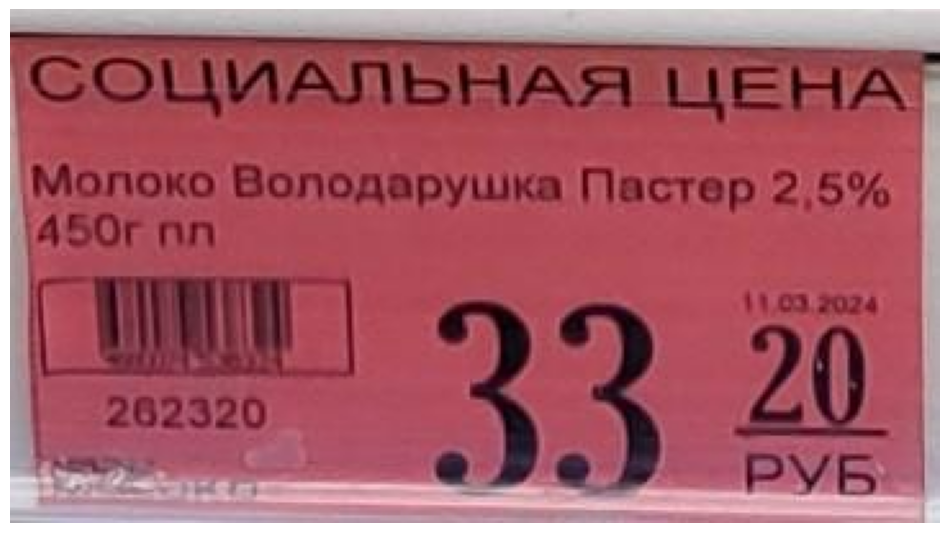

In [5]:
import supervision as sv

i = 1

file = files[i]

image = cv2.imread(os.path.join(base_path, file))

sv.plot_image(image)



0: 384x640 1 description, 1 price_whole, 1 price_fraction, 1 social_price_label, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 101.2ms postprocess per image at shape (1, 3, 384, 640)


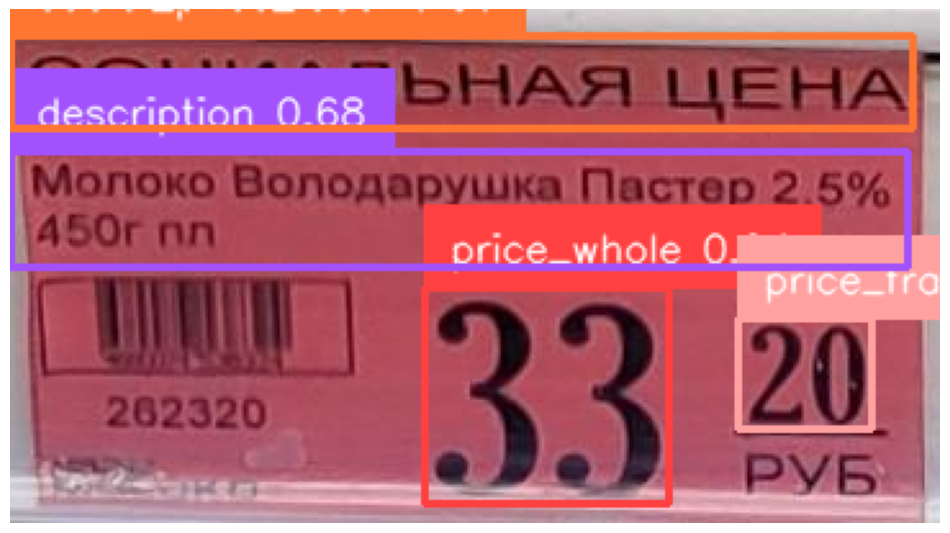

In [6]:
results = model(image)

detections = sv.Detections.from_ultralytics(results[0])

labels = [
    f"{model.names[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

bounding_box_annotator = sv.LabelAnnotator()
annotated_frame = bounding_box_annotator.annotate(
    scene=image.copy(),
    detections=detections, labels=labels
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
annotated_frame = bounding_box_annotator.annotate(
    scene=annotated_frame,
    detections=detections
)

sv.plot_image(image=annotated_frame)

In [8]:
from price_tag_analyzer.process import process, ProcessException

try: 
    imginfo = process(
        image,
        model,
        reader,
        spellchecker,
    )

    print(imginfo)

    print(f'Product: {imginfo.product}')
    print(f'Price: {imginfo.price}')
except ProcessException as e:
    print('Erorr: ', e.json_dump())

2024-04-14 01:52:53.596 | DEBUG    | price_tag_analyzer.process:process:252 - YOLO: 0.02 sec
2024-04-14 01:52:53.642 | INFO     | price_tag_analyzer.process:ocr:111 - СОЦИАЛЬНЫЙ ТОВАР!
2024-04-14 01:52:53.683 | DEBUG    | price_tag_analyzer.process:process:283 - OCR: 0.09 sec
2024-04-14 01:52:55.534 | DEBUG    | price_tag_analyzer.process:process:296 - Spellcheck: 1.85 sec
2024-04-14 01:52:55.535 | DEBUG    | price_tag_analyzer.process:process:298 - Description: Мопоко Воподарушка Пастор 2,5% A5Or nn
2024-04-14 01:52:55.535 | DEBUG    | price_tag_analyzer.process:process:299 - Fixed description: молоко воподарушка пастор 2,5% 450г in
2024-04-14 01:52:55.537 | DEBUG    | price_tag_analyzer.process:process:311 - NER: 0.00 sec


ImageInfo(product='Молоко пастеризованное', description='молоко воподарушка пастор 2,5% 450г in', price=33.2, measure=Measure(amount=450, unit='грамм'), attributes={'fat_content': '2.5', 'milk_type': 'пастеризованное'})
Product: Молоко пастеризованное
Price: 33.2
